# Transfer Learning (VGG16) Notebook

### Lets import our Dependencies

In [2]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
from PIL import Image

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np 
import os

### Load dataset
Function that loads a given dataset and pre-processes it before dumping it in their respective numpy-array.

In [3]:
def load_dataset(dataset):
    processed_images = []
    extracted_bboxes = []

    for item in os.listdir(dataset):
        if item.endswith('.jpg'):
            img_path = os.path.join(dataset, item)
            
            # Load the image and resize to 224x224
            img = img_to_array(load_img(img_path, target_size=(224, 224)))
            processed_images.append(img)

            # Extract bounding box information from corresponding XML file
            xml_filename = os.path.splitext(item)[0] + '.xml'
            tree = ET.parse(os.path.join(dataset, xml_filename))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            x1, y1, x2, y2 = map(int, [bndbox.find(x).text for x in ['xmin', 'ymin', 'xmax', 'ymax']])
            img_shape = Image.open(img_path).size
            scale_x, scale_y = 224 / img_shape[1], 224 / img_shape[0]
            scaled_x1, scaled_y1, scaled_x2, scaled_y2 = map(int, [x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y])
            extracted_bboxes.append([scaled_x1, scaled_y1, scaled_x2, scaled_y2])

    return np.array(processed_images), np.array(extracted_bboxes)

In [4]:
# Load and pre-process the dataset
Train_Images, Train_Bbox_Labels = load_dataset('../Dataset/train')
Test_Images,  Test_Bbox_Labels  = load_dataset('../Dataset/test')

c:\Users\ASCan\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Custom Model: Object Detection with VGG16 Architecture
The custom model is built upon Keras' VGG16-model, a powerful convolutional neural network commonly used in image recognition tasks. This custom adaptation aims to detect a specific class within images by retraining the VGG16-model on a tailored dataset. The process involves substituting the last connected layer with a new output layer designed to predict the bounding box coordinates of the targeted object within the image. 

The code provided demonstrates the steps taken to fine-tune the VGG16 model. The initial action involves loading the VGG16 model without its top classification layers. Subsequently, modifications are made by appending a Flatten layer to transform the output into a one-dimensional tensor. Following this, a Dense layer with 256 units and a ReLU activation function is added. The final custom layer comprises 4 units and employs a linear activation function to generate predictions for bounding box coordinates. The model is subsequently compiled using the mean squared error as the loss function and the Adam optimizer.

This refined explanation aims to elucidate the process of customizing the VGG16 model for object detection, providing a clearer understanding of the modifications made and their significance in the context of the model's architecture.

In [11]:
# Load VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=[224, 224, 3])

# Flatten the output and add custom output layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)

# Output layer for object detection
bbox_output = Dense(4, activation='linear')(x) # Bounding box coordinate predictions

# Create a new model with custom input and output layer
Custom_VGG16 = Model(inputs=base_model.input, outputs=bbox_output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
Custom_VGG16.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
hist = Custom_VGG16.fit(Train_Images, Train_Bbox_Labels, validation_data=(Test_Images, Test_Bbox_Labels), epochs=15, batch_size=32)

Epoch 1/15
8/8 [==============================] - 23s 3s/step - loss: 12157.7207 - mean_squared_error: 12157.7207 - val_loss: 3733.7112 - val_mean_squared_error: 3733.7112
Epoch 2/15
8/8 [==============================] - 22s 3s/step - loss: 5374.1064 - mean_squared_error: 5374.1064 - val_loss: 3450.9114 - val_mean_squared_error: 3450.9114
Epoch 3/15
8/8 [==============================] - 22s 3s/step - loss: 2728.9419 - mean_squared_error: 2728.9419 - val_loss: 2775.2454 - val_mean_squared_error: 2775.2454
Epoch 4/15
8/8 [==============================] - 22s 3s/step - loss: 1427.3118 - mean_squared_error: 1427.3118 - val_loss: 2280.3438 - val_mean_squared_error: 2280.3438
Epoch 5/15
8/8 [==============================] - 22s 3s/step - loss: 697.1649 - mean_squared_error: 697.1649 - val_loss: 2177.1382 - val_mean_squared_error: 2177.1382
Epoch 6/15
8/8 [==============================] - 22s 3s/step - loss: 397.9167 - mean_squared_error: 397.9167 - val_loss: 2247.1345 - val_mean_squared

## Loss Trend
Based on the loss trend observed in the training process and depicted in the histogram below, I opted for 10 epochs in my training code. It becomes apparent from the histogram that the loss plateaus and stops decreasing significantly after approximately eight epochs.

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Custom_VGG16 Loss Histogram')
    plt.xlabel('Amount of Epochs')
    plt.ylabel('Amount of Loss')
    plt.legend()
    plt.show()

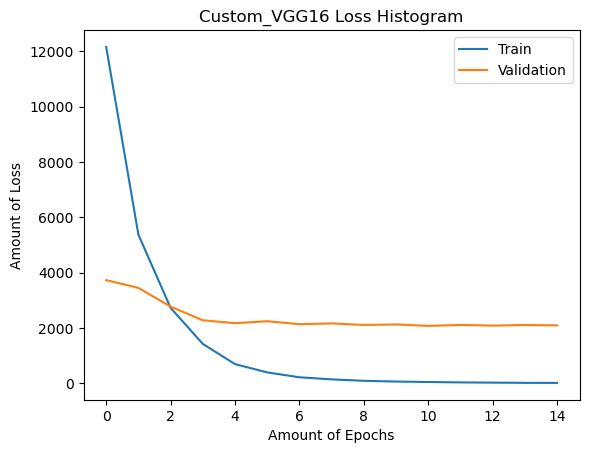

In [13]:
plot_loss(hist)

## Validation of the Model
As can be seen in the images, my model can usually extract the car from the image. The bounding box is not always perfectly around the car, but it usually identifies the headlights. It sometimes struggles with clouds and mountains, where the model can be completely wrong.

1/1 [==============================] - 0s 261ms/step
[[ 53.85873   56.716328 188.64265  171.75615 ]]


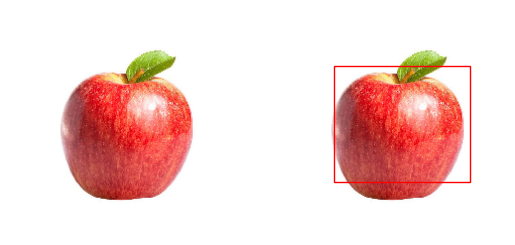

1/1 [==============================] - 0s 114ms/step
[[ 71.62327   31.726171 193.44374  131.56546 ]]


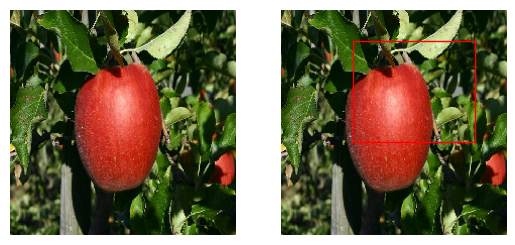

1/1 [==============================] - 0s 120ms/step
[[ 97.79898  39.71619 271.02103 159.49405]]


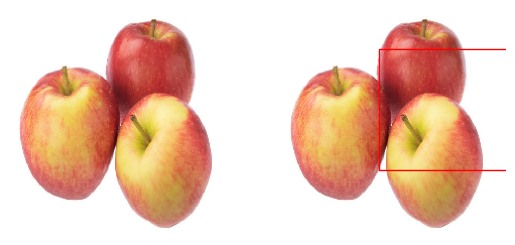

1/1 [==============================] - 0s 120ms/step
[[ 44.669308  47.012684 236.3083   157.58809 ]]


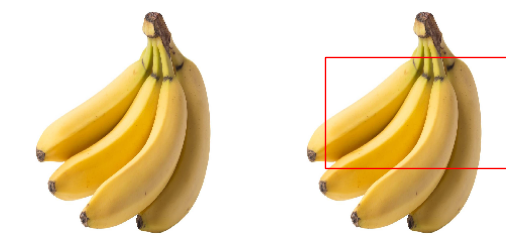

1/1 [==============================] - 0s 122ms/step
[[ 41.573875   9.57186  173.43651   69.01734 ]]


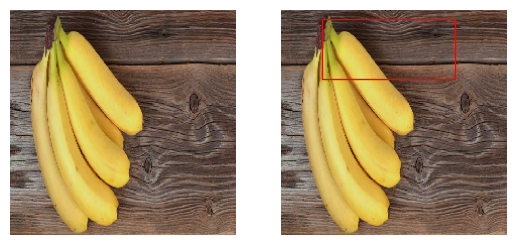

1/1 [==============================] - 0s 119ms/step
[[ 46.378162   8.999308 144.85501  110.15796 ]]


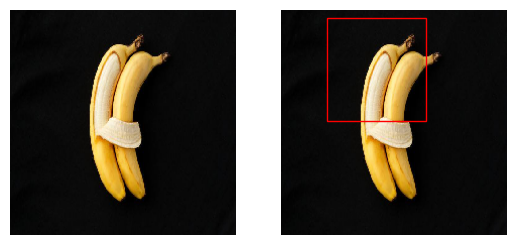

1/1 [==============================] - 0s 133ms/step
[[ 26.865433  28.250593 200.20494  198.19441 ]]


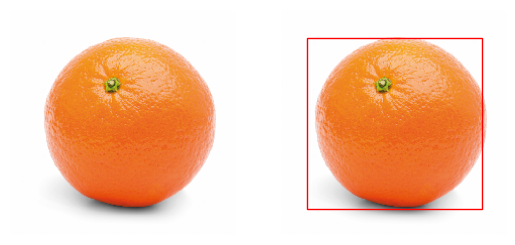

1/1 [==============================] - 0s 134ms/step
[[ 77.611     32.854877 201.30568  110.85368 ]]


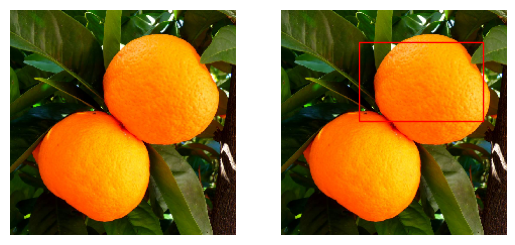

1/1 [==============================] - 0s 134ms/step
[[ 39.103592  18.837688 169.15326  111.010445]]


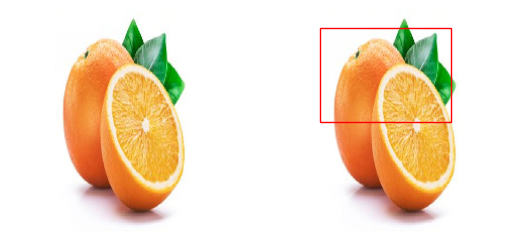

In [14]:
def load_images(dataset):
    processed_images = []

    for item in os.listdir(dataset):        
        # Load the image and resize to 224x224
        img = img_to_array(load_img(os.path.join(dataset, item), target_size=(224, 224)))
        processed_images.append(img)
    
    return processed_images

validation_images = load_images('../Dataset/validation')

# Display one image without and one image with bounding boxes.
def display_image(path, x1, y1, x2, y2):

    normalized_img = path.astype('float32') / 255.0  # Normalize image to retain original color
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(normalized_img)
    ax[1].imshow(normalized_img)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

    # Loop through the image filenames and process each image
for index in range(len(validation_images)):
    image = np.expand_dims(validation_images[index], axis=0)
    preds = Custom_VGG16.predict(image)
    print(preds)
    x1, y1, x2, y2 = preds.astype('int')[0]
    display_image(validation_images[index], x1, y1, x2, y2)
